In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow_addons as tfa

In [2]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    angle = tf.random.uniform([], -0.2, 0.2)  # 랜덤 각도 생성
    image = tfa.image.rotate(image, angle)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)  # 랜덤 대비 조절
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=32, AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2) 
    ds = ds.shuffle(buffer_size=shuffle_buffer_size) 
    ds = ds.repeat() 
    ds = ds.batch(32) 
    ds = ds.prefetch(buffer_size=AUTOTUNE) 
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)

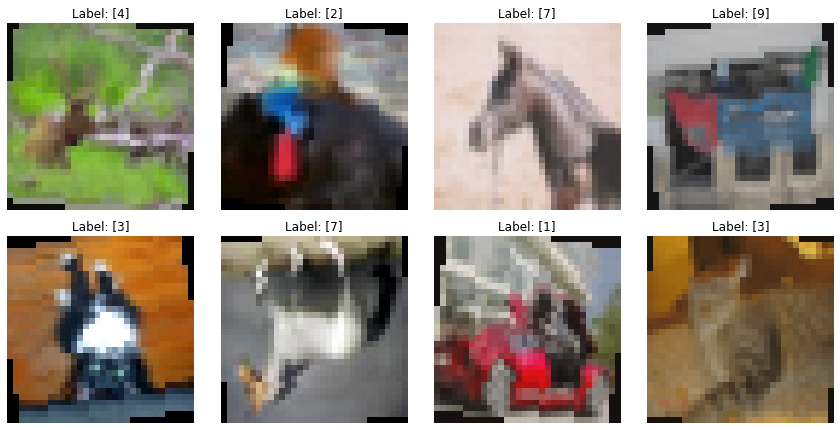

In [3]:
sample_batch = next(iter(train_ds))
augmented_images, augmented_labels = sample_batch
num_images_to_show = 8
plt.figure(figsize=(12, 12))
for i in range(num_images_to_show):
    ax = plt.subplot(4, 4, i+1)
    
    # vmin과 vmax를 지정하여 색상 맵 설정
    plt.imshow(augmented_images[i], vmin=0., vmax=1.)
    
    plt.title(f"Label: {augmented_labels[i].numpy()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [4]:
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [5]:
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [7]:
# class TestLossCallback(Callback):
#     def __init__(self, test_data, evaluation_interval):
#         super(TestLossCallback, self).__init__()
#         self.test_data = test_data
#         self.evaluation_interval = evaluation_interval
#         self.counter = 0

#     def on_epoch_end(self, epoch, logs=None):
#         self.counter += 1
#         if self.counter % self.evaluation_interval == 0:
#             test_loss, _ = self.model.evaluate(self.test_data[0], self.test_data[1], verbose=0)
#             self.model.test_loss = test_loss  # 모델 객체에 테스트 데이터의 loss 값을 저장
#             self.counter = 0  # 카운터 초기화
# test_loss_callback = TestLossCallback(test_data=(x_test, y_test),evaluation_interval=10)
# early_stopping = EarlyStopping(monitor='test_loss', mode='min', patience=3, restore_best_weights=True)

In [8]:
# 학습 루프
num_epochs = 100

# steps_per_epoch를 설정합니다. 
steps_per_epoch = len(x_train) // 32

# 학습을 수행합니다.
history = model.fit(train_ds, 
                    epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/100
1562/1562 [==============================] - 141s 84ms/step - loss: 1.5876 - accuracy: 0.4233
Epoch 2/100
1562/1562 [==============================] - 132s 84ms/step - loss: 1.1266 - accuracy: 0.5968
Epoch 3/100
1562/1562 [==============================] - 132s 84ms/step - loss: 0.9431 - accuracy: 0.6633
Epoch 4/100
1562/1562 [==============================] - 132s 84ms/step - loss: 0.8250 - accuracy: 0.7077
Epoch 5/100
1562/1562 [==============================] - 131s 84ms/step - loss: 0.7435 - accuracy: 0.7380
Epoch 6/100
1562/1562 [==============================] - 131s 84ms/step - loss: 0.6752 - accuracy: 0.7616
Epoch 7/100
1562/1562 [==============================] - 131s 84ms/step - loss: 0.6135 - accuracy: 0.7851
Epoch 8/100
1562/1562 [==============================] - 132s 84ms/step - loss: 0.5678 - accuracy: 0.8013
Epoch 9/100
1562/1562 [==============================] - 131s 84ms/step - loss: 0.5224 - accuracy: 0.8170
Epoch 10/100
1562/1562 [======================

In [9]:
# 모델 평가
test_loss, test_acc = model.evaluate(test_ds.batch(32))
print(f"Test accuracy: {test_acc * 100:.2f}%")

313/313 [==============================] - 4s 12ms/step - loss: 0.5339 - accuracy: 0.8859
Test accuracy: 88.59%


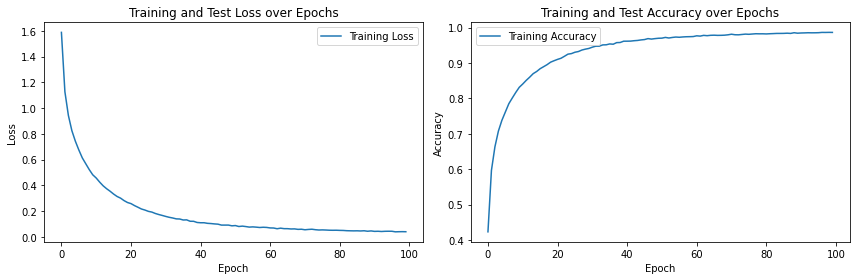

In [10]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# 훈련 손실 및 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
if hasattr(model, 'test_loss'):  # TestLossCallback가 test_loss를 저장한 경우에만 시각화
    plt.plot([i * test_loss_callback.evaluation_interval for i in range(len(history.history["loss"]))],
             [model.test_loss] * len(history.history["loss"]),
             label="Test Loss", linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()

# 훈련 정확도 및 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
if hasattr(model, 'test_loss'):  # TestLossCallback가 test_loss를 저장한 경우에만 시각화
    plt.plot([i * test_loss_callback.evaluation_interval for i in range(len(history.history["accuracy"]))],
             [test_acc] * len(history.history["accuracy"]),
             label="Test Accuracy", linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

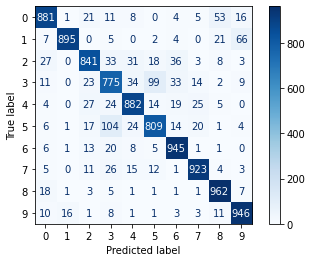

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes using the trained model
predicted_probs = model.predict(x_test)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display the confusion matrix
classes = [str(i) for i in range(10)]  # Assuming you have 10 classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
plt.show()

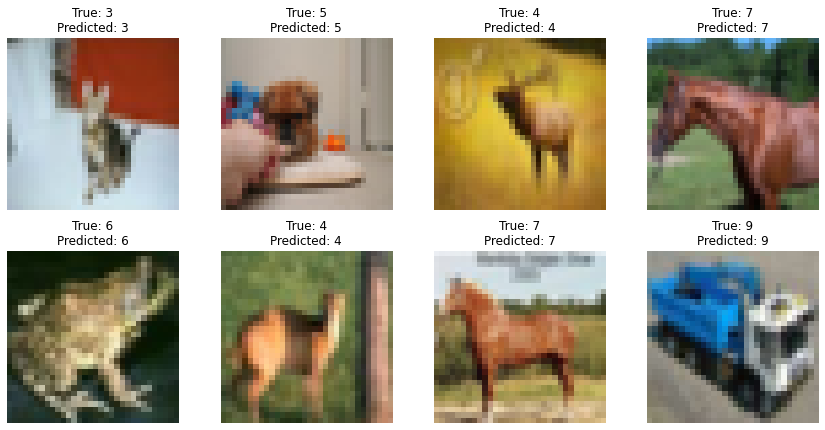

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Get some data to visualize
num_images_to_visualize = 8
sample_indices = np.random.randint(0, len(x_test), num_images_to_visualize)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Predict classes using the trained model
predicted_probs = model.predict(sample_images)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Visualize the predicted results
plt.figure(figsize=(12, 12))
for i in range(num_images_to_visualize):
    plt.subplot(4, 4, i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_labels[i][0]}\nPredicted: {predicted_classes[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()